<hr/>

<hr/>

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install toad

     |████████████████████████████████| 14.8 MB 2.1 MB/s            
     |████████████████████████████████| 292 kB 62.9 MB/s            
     |████████████████████████████████| 2.0 MB 48.5 MB/s            
     |████████████████████████████████| 14.8 MB 42.0 MB/s            
     |████████████████████████████████| 14.8 MB 40.0 MB/s            
     |████████████████████████████████| 14.8 MB 51.5 MB/s            
     |████████████████████████████████| 14.8 MB 44.4 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.12
    Uninstalling Cython-0.29.12:
      Successfully uninstalled Cython-0.29.12
ERROR: pip's dependency resolver does not curren

## <span id="1"></span> ** 1. Overview **

## <span id="2"></span> ** 2. Importing Libraries and Reading the Dataset **

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from IPython.core.display import display, HTML
from sklearn import datasets
from matplotlib import pyplot as plt
import toad
import jieba
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')

In [219]:
import time
from sklearn.datasets import load_boston
dataset = pd.read_excel("/input/fxmonth/USD_CHF_Month.xlsx")
dataset.columns

Index(['Underlying', 'Type', 'Strike', 'Expiry', 'Notional', 'Curr', 'Premium',
       'Curr.1', 'Style', 'Code', 'Clr', 'Trd Time'],
      dtype='object')

In [220]:
d_min = pd.read_excel("/input/minute/USD_CHF_Minute.xlsx")
d_min.head()

Date      ER
0  2022-11-24T00:00:00.000Z  0.9408
1  2022-11-23T23:59:00.000Z  0.9410
2  2022-11-23T23:58:00.000Z  0.9410
3  2022-11-23T23:57:00.000Z  0.9408
4  2022-11-23T23:56:00.000Z  0.9410

**Converts the string time to a unix timestamp**

In [221]:
def Changetime(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%m/%d/%Y %H:%M:%S'))*1000)
    except:
        print("**"+str1)
    return Unixtime


In [222]:
def Changetime1(str1):
    try:
        str1 = str(str1)
        Unixtime = int(time.mktime(time.strptime(str1, '%Y-%m-%dT%H:%M:%S.000Z'))*1000)
    except:
        print("**"+str1)
    return Unixtime

Changetime1('2022-11-24T00:00:00.000Z')

1669248000000

per ms
1 1ms
1s 1000
1hour 3600000
1day 86400000
1week 604800000
1month 2629743000

In [223]:
dataset["Trd Time"] = dataset["Trd Time"].apply(Changetime)


In [224]:
d_min["ER"]

0        0.9408
1        0.9410
2        0.9410
3        0.9408
4        0.9410
5        0.9411
6        0.9411
7        0.9408
8        0.9410
9        0.9409
10       0.9411
11       0.9410
12       0.9410
13       0.9412
14       0.9411
15       0.9411
16       0.9410
17       0.9412
18       0.9412
19       0.9410
20       0.9411
21       0.9413
22       0.9411
23       0.9411
24       0.9412
25       0.9413
26       0.9413
27       0.9411
28       0.9411
29       0.9411
          ...  
38324    0.9948
38325    0.9949
38326    0.9949
38327    0.9949
38328    0.9949
38329    0.9952
38330    0.9953
38331    0.9953
38332    0.9951
38333    0.9950
38334    0.9954
38335    0.9954
38336    0.9953
38337    0.9951
38338    0.9952
38339    0.9951
38340    0.9952
38341    0.9952
38342    0.9953
38343    0.9953
38344    0.9953
38345    0.9953
38346    0.9952
38347    0.9953
38348    0.9952
38349    0.9952
38350    0.9952
38351    0.9951
38352    0.9950
38353    0.9950
Name: ER, Length: 38354,

In [225]:
d_min["Date"] = d_min["Date"].apply(Changetime1)

In [226]:
dataset.head()

Underlying Type  Strike    Expiry  Notional Curr   Premium  \
0  USD CAD Vanilla Option    C  1.4050  08/18/23  20000000  USD  264500.0   
1  USD CAD Vanilla Option    C  1.3385  11/21/22  15000000  USD   21000.0   
2  USD CAD Vanilla Option    C  1.3450  11/30/22  30000000  USD   96000.0   
3  USD CAD Vanilla Option    C  1.3635  12/20/22  30000000  USD  128250.0   
4  USD CAD Vanilla Option    C  1.4050  08/18/23  30000000  USD  396750.0   

  Curr.1 Style Code Clr       Trd Time  
0    USD    EU   TR   U  1668789236000  
1    USD    EU   TR   U  1668789038000  
2    USD    EU   TR   U  1668788844000  
3    USD    EU   TR   U  1668788449000  
4    USD    EU   TR   U  1668788435000

## <span id="2"></span> ** 2. data encoding **

In [227]:
dataset["Trd Time"].isnull().sum()
print(len(dataset["Trd Time"]))
print(dataset["Trd Time"][len(dataset["Trd Time"])-1])

2320
1666168731000


**find er after 1min / 30 min / 1 hour /1 day**

In [228]:
def find1min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10000 and (a-i)<10*60000):
            return j
    return -1
dataset["1min"] = dataset["Trd Time"].apply(find1min_er)
dataset["1min"].value_counts()

 1.0004    47
 1.0005    34
 0.9916    28
 0.9441    25
 0.9899    24
 1.0021    23
 0.9895    22
 0.9896    22
 0.9978    21
 0.9888    21
 0.9890    19
 1.0024    19
 1.0026    19
 1.0016    18
 1.0023    17
 1.0020    16
 0.9900    16
 0.9892    15
 0.9452    15
 1.0035    14
 0.9988    14
 1.0012    13
 0.9891    13
 0.9905    13
 0.9445    13
 0.9985    12
 0.9997    12
 0.9511    12
 1.0011    12
 0.9894    12
           ..
 0.9465     1
 0.9471     1
 0.9879     1
 0.9613     1
 1.0117     1
 1.0086     1
 0.9875     1
 0.9587     1
 0.9495     1
 0.9788     1
 0.9866     1
 1.0114     1
 1.0110     1
 0.9561     1
 0.9870     1
 0.9598     1
 0.9604     1
 0.9944     1
 0.9585     1
 0.9469     1
 1.0055     1
 0.9634     1
 1.0141     1
 0.9929     1
 0.9438     1
 0.9683     1
 0.9506     1
 0.9641     1
 0.9590     1
-1.0000     1
Name: 1min, Length: 474, dtype: int64

In [229]:
def find30min_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>10*60000 and (a-i)<50*60000):
            return j
    return -1
dataset["30min"] = dataset["Trd Time"].apply(find1min_er)
dataset["30min"].value_counts()

 1.0004    47
 1.0005    34
 0.9916    28
 0.9441    25
 0.9899    24
 1.0021    23
 0.9895    22
 0.9896    22
 0.9978    21
 0.9888    21
 0.9890    19
 1.0024    19
 1.0026    19
 1.0016    18
 1.0023    17
 1.0020    16
 0.9900    16
 0.9892    15
 0.9452    15
 1.0035    14
 0.9988    14
 1.0012    13
 0.9891    13
 0.9905    13
 0.9445    13
 0.9985    12
 0.9997    12
 0.9511    12
 1.0011    12
 0.9894    12
           ..
 0.9465     1
 0.9471     1
 0.9879     1
 0.9613     1
 1.0117     1
 1.0086     1
 0.9875     1
 0.9587     1
 0.9495     1
 0.9788     1
 0.9866     1
 1.0114     1
 1.0110     1
 0.9561     1
 0.9870     1
 0.9598     1
 0.9604     1
 0.9944     1
 0.9585     1
 0.9469     1
 1.0055     1
 0.9634     1
 1.0141     1
 0.9929     1
 0.9438     1
 0.9683     1
 0.9506     1
 0.9641     1
 0.9590     1
-1.0000     1
Name: 30min, Length: 474, dtype: int64

In [230]:
def find1h_er(a):
    for i,j in zip(d_min['Date'], d_min['ER']):
        if((a-i)>60*60000 and (a-i)<120*60000):
            return j
    return -1
dataset["1h"] = dataset["Trd Time"].apply(find1min_er)
dataset["1h"].value_counts()

 1.0004    47
 1.0005    34
 0.9916    28
 0.9441    25
 0.9899    24
 1.0021    23
 0.9895    22
 0.9896    22
 0.9978    21
 0.9888    21
 0.9890    19
 1.0024    19
 1.0026    19
 1.0016    18
 1.0023    17
 1.0020    16
 0.9900    16
 0.9892    15
 0.9452    15
 1.0035    14
 0.9988    14
 1.0012    13
 0.9891    13
 0.9905    13
 0.9445    13
 0.9985    12
 0.9997    12
 0.9511    12
 1.0011    12
 0.9894    12
           ..
 0.9465     1
 0.9471     1
 0.9879     1
 0.9613     1
 1.0117     1
 1.0086     1
 0.9875     1
 0.9587     1
 0.9495     1
 0.9788     1
 0.9866     1
 1.0114     1
 1.0110     1
 0.9561     1
 0.9870     1
 0.9598     1
 0.9604     1
 0.9944     1
 0.9585     1
 0.9469     1
 1.0055     1
 0.9634     1
 1.0141     1
 0.9929     1
 0.9438     1
 0.9683     1
 0.9506     1
 0.9641     1
 0.9590     1
-1.0000     1
Name: 1h, Length: 474, dtype: int64

In [231]:
def find1d_er(a):
    for i,j in zip(d_min['Date'], d_min['EUR=']):
        if((a-i)>24*60*60000 and (a-i)<48*60*60000):
            return j
    return -1
dataset["1d"] = dataset["Trd Time"].apply(find1min_er)
dataset["1d"].value_counts()

 1.0004    47
 1.0005    34
 0.9916    28
 0.9441    25
 0.9899    24
 1.0021    23
 0.9895    22
 0.9896    22
 0.9978    21
 0.9888    21
 0.9890    19
 1.0024    19
 1.0026    19
 1.0016    18
 1.0023    17
 1.0020    16
 0.9900    16
 0.9892    15
 0.9452    15
 1.0035    14
 0.9988    14
 1.0012    13
 0.9891    13
 0.9905    13
 0.9445    13
 0.9985    12
 0.9997    12
 0.9511    12
 1.0011    12
 0.9894    12
           ..
 0.9465     1
 0.9471     1
 0.9879     1
 0.9613     1
 1.0117     1
 1.0086     1
 0.9875     1
 0.9587     1
 0.9495     1
 0.9788     1
 0.9866     1
 1.0114     1
 1.0110     1
 0.9561     1
 0.9870     1
 0.9598     1
 0.9604     1
 0.9944     1
 0.9585     1
 0.9469     1
 1.0055     1
 0.9634     1
 1.0141     1
 0.9929     1
 0.9438     1
 0.9683     1
 0.9506     1
 0.9641     1
 0.9590     1
-1.0000     1
Name: 1d, Length: 474, dtype: int64

In [232]:
dataset.head()

Underlying Type  Strike    Expiry  Notional Curr   Premium  \
0  USD CAD Vanilla Option    C  1.4050  08/18/23  20000000  USD  264500.0   
1  USD CAD Vanilla Option    C  1.3385  11/21/22  15000000  USD   21000.0   
2  USD CAD Vanilla Option    C  1.3450  11/30/22  30000000  USD   96000.0   
3  USD CAD Vanilla Option    C  1.3635  12/20/22  30000000  USD  128250.0   
4  USD CAD Vanilla Option    C  1.4050  08/18/23  30000000  USD  396750.0   

  Curr.1 Style Code Clr       Trd Time    1min   30min      1h      1d  
0    USD    EU   TR   U  1668789236000  0.9510  0.9510  0.9510  0.9510  
1    USD    EU   TR   U  1668789038000  0.9508  0.9508  0.9508  0.9508  
2    USD    EU   TR   U  1668788844000  0.9506  0.9506  0.9506  0.9506  
3    USD    EU   TR   U  1668788449000  0.9504  0.9504  0.9504  0.9504  
4    USD    EU   TR   U  1668788435000  0.9504  0.9504  0.9504  0.9504

In [233]:
def hotEncoding(NAME):
    value = dataset[NAME].value_counts()
    value_map = dict((v, i) for i,v in enumerate(value.index))
    dataset[NAME] = dataset.replace({NAME:value_map})[NAME]
hotEncoding('Underlying') 

In [234]:
def typecoding(NAME): 
    value1 = dataset[NAME].astype('category')
    dataset[NAME] = value1.cat.codes
typecoding('Curr')
typecoding('Type')
typecoding('Curr.1')
typecoding('Style')
typecoding('Code')
typecoding('Clr')
dataset['Underlying'] = dataset['Underlying'] +1
dataset['Type'] = dataset['Type'] +1
dataset['Curr'] = dataset['Curr'] +1
dataset['Curr.1'] = dataset['Curr.1'] +1
dataset.head()

Underlying  Type  Strike    Expiry  Notional  Curr   Premium  Curr.1  \
0           1     1  1.4050  08/18/23  20000000     1  264500.0       2   
1           1     1  1.3385  11/21/22  15000000     1   21000.0       2   
2           1     1  1.3450  11/30/22  30000000     1   96000.0       2   
3           1     1  1.3635  12/20/22  30000000     1  128250.0       2   
4           1     1  1.4050  08/18/23  30000000     1  396750.0       2   

   Style  Code  Clr       Trd Time    1min   30min      1h      1d  
0      0     2    0  1668789236000  0.9510  0.9510  0.9510  0.9510  
1      0     2    0  1668789038000  0.9508  0.9508  0.9508  0.9508  
2      0     2    0  1668788844000  0.9506  0.9506  0.9506  0.9506  
3      0     2    0  1668788449000  0.9504  0.9504  0.9504  0.9504  
4      0     2    0  1668788435000  0.9504  0.9504  0.9504  0.9504

In [235]:
dataset = dataset.drop(['Expiry','Clr'], axis=1)
# dataset['toprice'] = dataset['Notional']/2+dataset['Premium']
# dataset['delrate'] = dataset['Premium']/(dataset['Curr']+1)
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
dataset.head()

Underlying  Type  Strike  Notional  Curr   Premium  Curr.1  Style  Code  \
0           1     1  1.4050  20000000     1  264500.0       2      0     2   
1           1     1  1.3385  15000000     1   21000.0       2      0     2   
2           1     1  1.3450  30000000     1   96000.0       2      0     2   
3           1     1  1.3635  30000000     1  128250.0       2      0     2   
4           1     1  1.4050  30000000     1  396750.0       2      0     2   

        Trd Time    1min   30min      1h      1d  
0  1668789236000  0.9510  0.9510  0.9510  0.9510  
1  1668789038000  0.9508  0.9508  0.9508  0.9508  
2  1668788844000  0.9506  0.9506  0.9506  0.9506  
3  1668788449000  0.9504  0.9504  0.9504  0.9504  
4  1668788435000  0.9504  0.9504  0.9504  0.9504

## <span id="3"></span> ** 3. Data Analysis **

### <span id="4"></span> ** Data Preprocessing **

Are there missing values? There isn't any missing values as shown below.

In [236]:
dataset= dataset.dropna()


### <span id="5"></span> ** using toad to perform exploratory data analysis and visualization**

In [237]:
dataset.isnull().sum()

Underlying    0
Type          0
Strike        0
Notional      0
Curr          0
Premium       0
Curr.1        0
Style         0
Code          0
Trd Time      0
1min          0
30min         0
1h            0
1d            0
dtype: int64

In [238]:
tance = toad.detector.detect(dataset)

In [239]:
tance

type  size missing  unique  mean_or_top1   std_or_top2  \
Underlying    int64  2320   0.00%       1  1.000000e+00  0.000000e+00   
Type           int8  2320   0.00%       1  1.000000e+00  0.000000e+00   
Strike      float64  2320   0.00%     409  1.363636e+00  6.758563e-02   
Notional      int64  2320   0.00%     114  2.920066e+07  3.519192e+07   
Curr           int8  2320   0.00%       1  1.000000e+00  0.000000e+00   
Premium     float64  2320   0.00%    1580  3.722396e+05  1.063659e+06   
Curr.1         int8  2320   0.00%       2  1.975431e+00  1.548408e-01   
Style          int8  2320   0.00%       1  0.000000e+00  0.000000e+00   
Code           int8  2320   0.00%       3  1.954310e+00  2.959821e-01   
Trd Time      int64  2320   0.00%    1753  1.667495e+12  7.796389e+08   
1min        float64  2320   0.00%     474  9.841553e-01  4.741437e-02   
30min       float64  2320   0.00%     474  9.841553e-01  4.741437e-02   
1h          float64  2320   0.00%     474  9.841553e-01  4.741437e-02   
1d          float64  2320   0.00%     474  9.841553e-01  4.741437e-02   

             min_or_top3    1%_or_top4   10%_or_top5  50%_or_bottom5  \
Underlying  1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Type        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Strike      1.000000e-04  1.280000e+00  1.324480e+00    1.360500e+00   
Notional    4.000000e+04  2.000000e+05  2.000000e+06    2.000000e+07   
Curr        1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00   
Premium     0.000000e+00  0.000000e+00  1.372500e+03    1.567500e+05   
Curr.1      1.000000e+00  1.000000e+00  2.000000e+00    2.000000e+00   
Style       0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
Code        0.000000e+00  0.000000e+00  2.000000e+00    2.000000e+00   
Trd Time    1.666169e+12  1.666178e+12  1.666357e+12    1.667468e+12   
1min       -1.000000e+00  9.394000e-01  9.445000e-01    9.933500e-01   
30min      -1.000000e+00  9.394000e-01  9.445000e-01    9.933500e-01   
1h         -1.000000e+00  9.394000e-01  9.445000e-01    9.933500e-01   
1d         -1.000000e+00  9.394000e-01  9.445000e-01    9.933500e-01   

            75%_or_bottom4  90%_or_bottom3  99%_or_bottom2  max_or_bottom1  
Underlying    1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Type          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Strike        1.380000e+00    1.410000e+00    1.546310e+00    1.900000e+00  
Notional      3.100000e+07    7.000000e+07    2.000000e+08    2.500000e+08  
Curr          1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00  
Premium       3.660000e+05    7.006875e+05    3.980958e+06    1.828900e+07  
Curr.1        2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Style         0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
Code          2.000000e+00    2.000000e+00    2.000000e+00    2.000000e+00  
Trd Time      1.668099e+12    1.668601e+12    1.668776e+12    1.668789e+12  
1min          1.001600e+00    1.008200e+00    1.013700e+00    1.014200e+00  
30min         1.001600e+00    1.008200e+00    1.013700e+00    1.014200e+00  
1h            1.001600e+00    1.008200e+00    1.013700e+00    1.014200e+00  
1d            1.001600e+00    1.008200e+00    1.013700e+00    1.014200e+00

## <span id="3"></span> 1. 1min model 

In [240]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1624, 2)
Shape of X_test:  (696, 2)
Shape of y_train:  (1624,)
Shape of y_test (696,)


In [241]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.008978274453409197
R2_score (train):  0.0025129573057508514
R2_score (test):  -0.001207195651323989
RMSE:  0.07877062276528331


In [242]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.12828589148624664
R2_score (train):  -0.09967881595215844
R2_score (test):  -0.01881076926084524
RMSE:  0.079460091612107


In [243]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [244]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.44241355034786156
R2_score (train):  0.9381167167518509
R2_score (test):  -0.054445292763605435
RMSE:  0.08083776992875771


In [245]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  0.07167230976973785
R2_score (train):  0.8304809570178187
R2_score (test):  0.009846158636480973
RMSE:  0.07833460110887297


In [246]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.078771            0.002513       -0.001207         -0.008978
1   SVM  0.079460           -0.099679        0.018811         -0.128286
2   KNN  0.080838            0.938117        0.054445          0.442414
3    RF  0.078335            0.830481        0.009846          0.071672

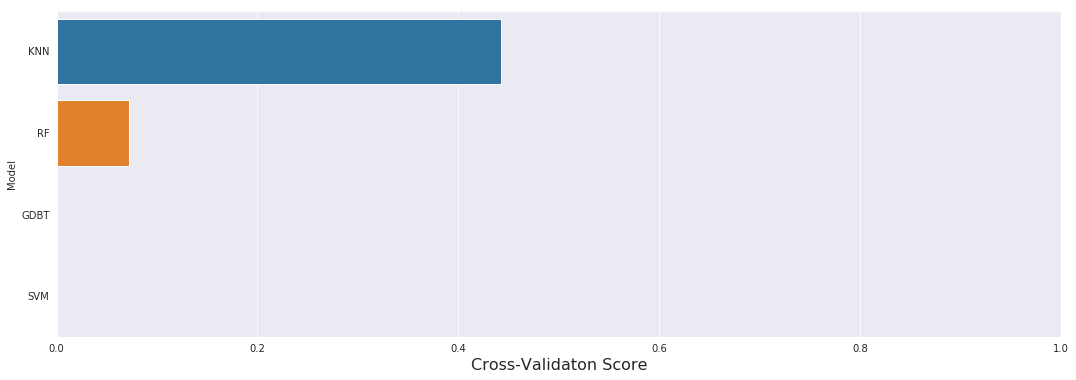

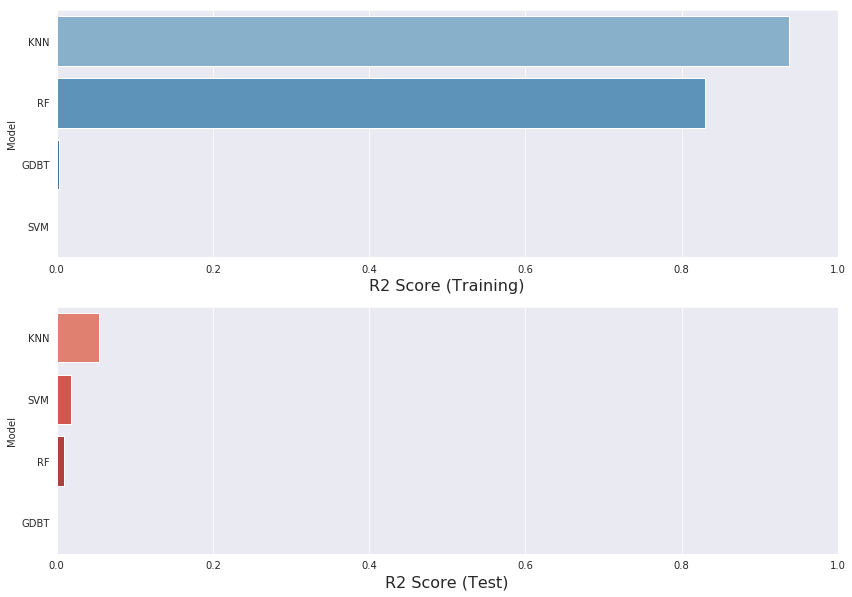

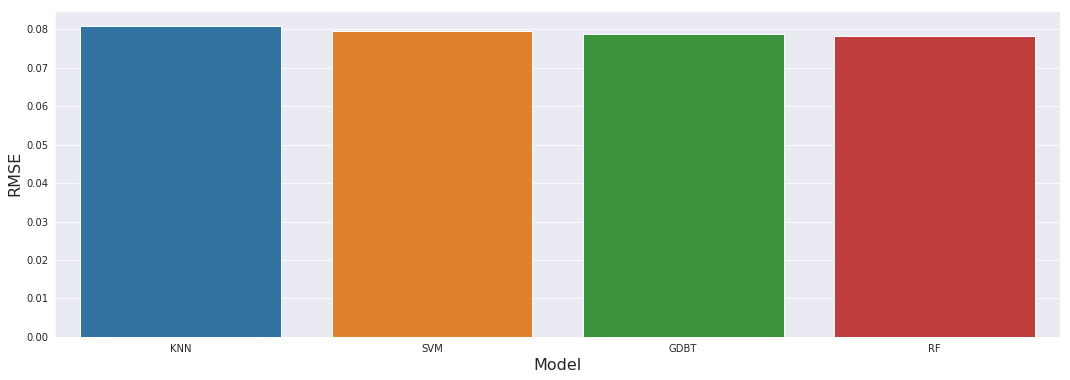

In [247]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 2. 30min model 

In [248]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,11]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1624, 2)
Shape of X_test:  (696, 2)
Shape of y_train:  (1624,)
Shape of y_test (696,)


In [249]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.008978274453409197
R2_score (train):  0.0025129573057508514
R2_score (test):  -0.001207195651323989
RMSE:  0.07877062276528331


In [250]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.12828589148624664
R2_score (train):  -0.09967881595215844
R2_score (test):  -0.01881076926084524
RMSE:  0.079460091612107


In [251]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [252]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.44241355034786156
R2_score (train):  0.9381167167518509
R2_score (test):  -0.054445292763605435
RMSE:  0.08083776992875771


In [253]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  0.07167230976973785
R2_score (train):  0.8304809570178187
R2_score (test):  0.009846158636480973
RMSE:  0.07833460110887297


In [254]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.078771            0.002513       -0.001207         -0.008978
1   SVM  0.079460           -0.099679        0.018811         -0.128286
2   KNN  0.080838            0.938117        0.054445          0.442414
3    RF  0.078335            0.830481        0.009846          0.071672

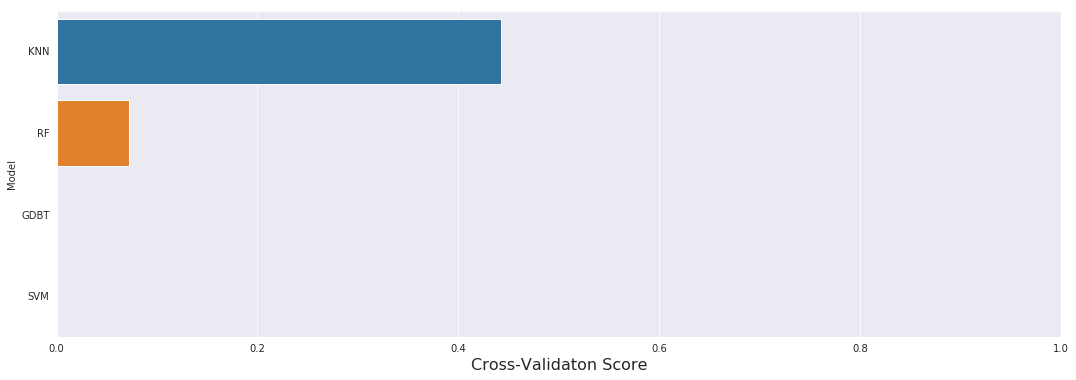

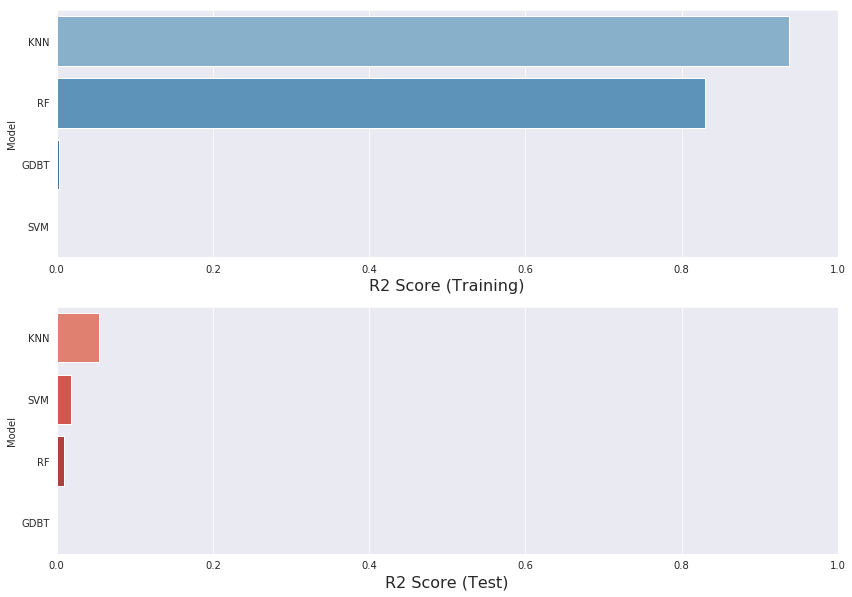

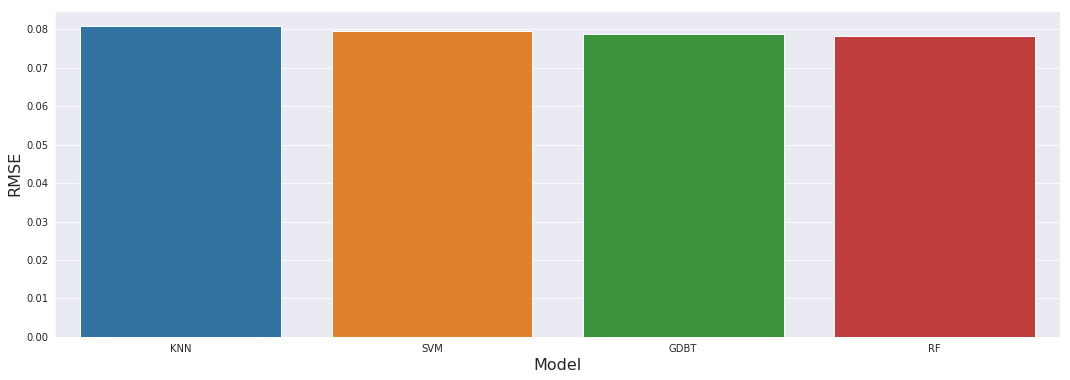

In [255]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 3. 1hour model 

In [256]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1624, 2)
Shape of X_test:  (696, 2)
Shape of y_train:  (1624,)
Shape of y_test (696,)


In [257]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.008978274453409197
R2_score (train):  0.0025129573057508514
R2_score (test):  -0.001207195651323989
RMSE:  0.07877062276528331


In [258]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.12828589148624664
R2_score (train):  -0.09967881595215844
R2_score (test):  -0.01881076926084524
RMSE:  0.079460091612107


In [259]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [260]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.44241355034786156
R2_score (train):  0.9381167167518509
R2_score (test):  -0.054445292763605435
RMSE:  0.08083776992875771


In [261]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  0.07167230976973785
R2_score (train):  0.8304809570178187
R2_score (test):  0.009846158636480973
RMSE:  0.07833460110887297


In [262]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.078771            0.002513       -0.001207         -0.008978
1   SVM  0.079460           -0.099679        0.018811         -0.128286
2   KNN  0.080838            0.938117        0.054445          0.442414
3    RF  0.078335            0.830481        0.009846          0.071672

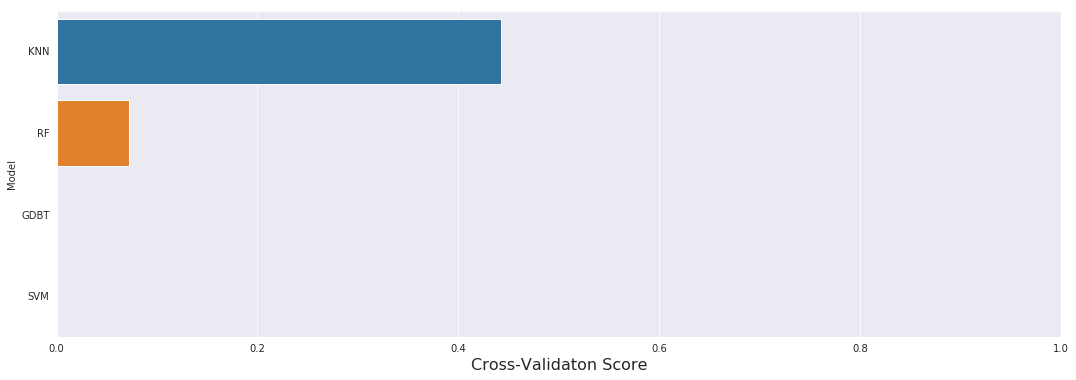

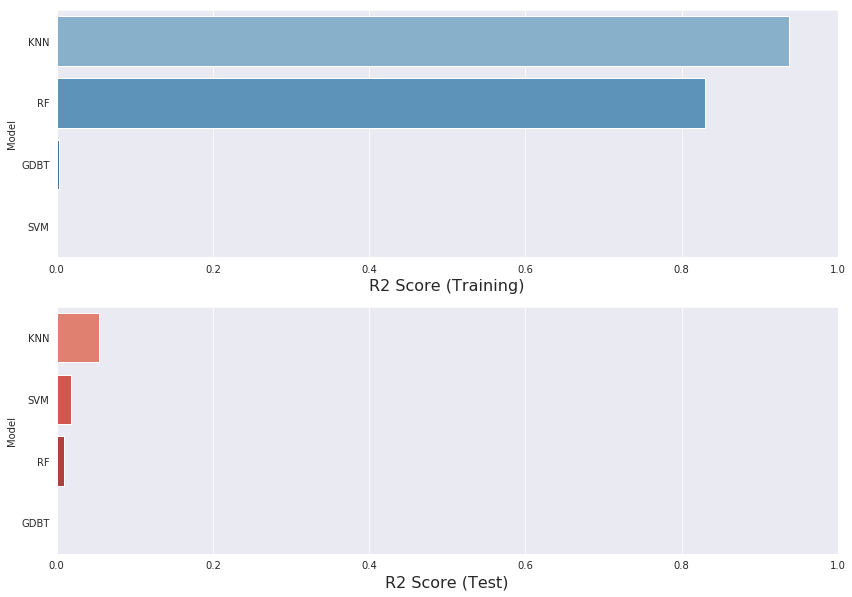

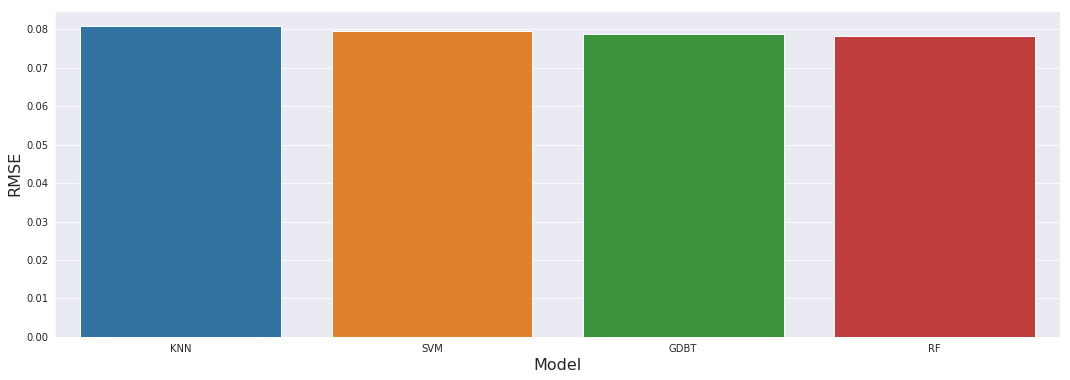

In [263]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="3"></span> 1. 1day model 

In [264]:
X = dataset[['Notional','Premium']].iloc[:,:]

y = dataset.iloc[:,10]
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1624, 2)
Shape of X_test:  (696, 2)
Shape of y_train:  (1624,)
Shape of y_test (696,)


In [265]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

CV:  -0.008978274453409197
R2_score (train):  0.0025129573057508514
R2_score (test):  -0.001207195651323989
RMSE:  0.07877062276528331


In [266]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

CV:  -0.12828589148624664
R2_score (train):  -0.09967881595215844
R2_score (test):  -0.01881076926084524
RMSE:  0.079460091612107


In [267]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression

In [268]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

CV:  -0.44241355034786156
R2_score (train):  0.9381167167518509
R2_score (test):  -0.054445292763605435
RMSE:  0.08083776992875771


In [269]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

CV:  0.07167230976973785
R2_score (train):  0.8304809570178187
R2_score (test):  0.009846158636480973
RMSE:  0.07833460110887297


In [270]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

Model      RMSE  R2_Score(training)  R2_Score(test)  Cross-Validation
0  GDBT  0.078771            0.002513       -0.001207         -0.008978
1   SVM  0.079460           -0.099679        0.018811         -0.128286
2   KNN  0.080838            0.938117        0.054445          0.442414
3    RF  0.078335            0.830481        0.009846          0.071672

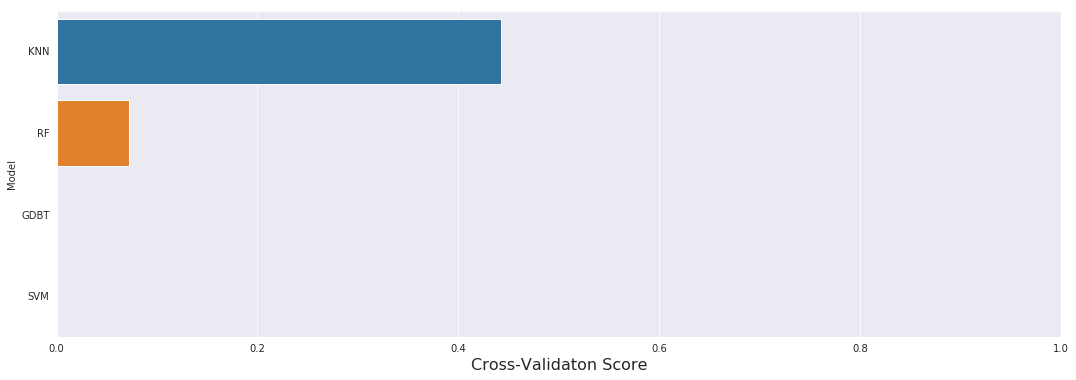

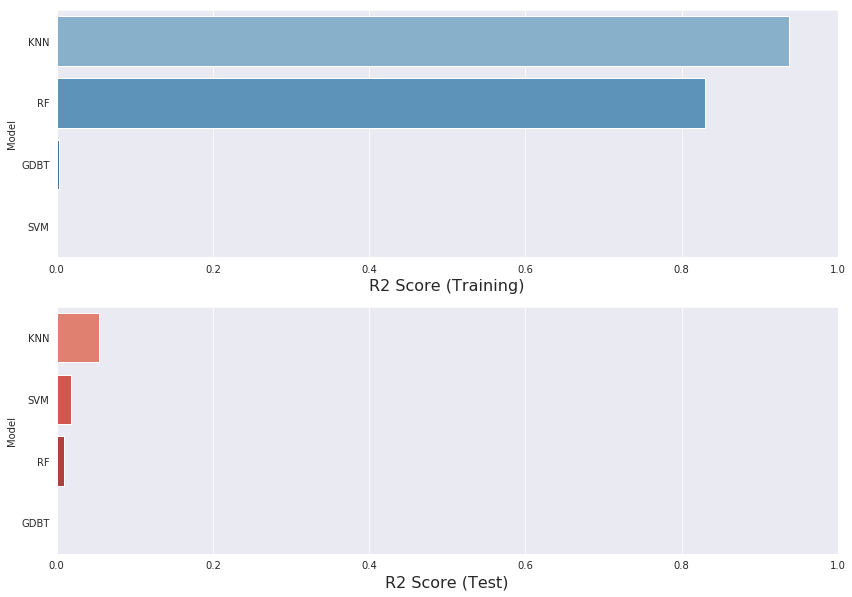

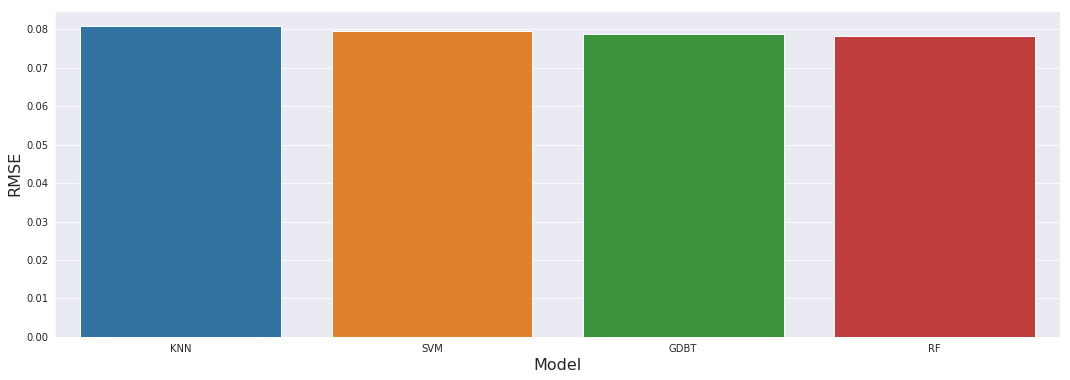

In [271]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()


predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

------------

**origin **

------------

In [ ]:
y = dataset.iloc[:,5]
X = dataset.drop('Premium', axis=1).iloc[:,:]

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [ ]:
dataset.head()

In [ ]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

### <span id="5"></span> ** Visualizing Data **

### <span id="5"></span> **Correlations can be found by thermal maps **

In [ ]:
corr = dataset.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

In [ ]:
sns.pairplot(dataset)
plt.show()

## <span id="6"></span> ** 4. Regression Models **

### <span id="7"></span> ** gdbt **

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn import ensemble
# Predicting Cross Validation Score the Test set results
cv = cross_val_score(estimator = regressor, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_train = regressor.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)

# Predicting R2 Score the Test set results
y_pred_test = regressor.predict(X_test)
r2_score_test = r2_score(y_test, y_pred_test)

# Predicting RMSE the Test set results
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("CV: ", cv.mean())
print('R2_score (train): ', r2_score_train)
print('R2_score (test): ', r2_score_test)
print("RMSE: ", rmse)

### <span id="11"></span> ** SVM **

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
regressor_svr = SVR(kernel = 'rbf', gamma = 'scale')
regressor_svr.fit(X_scaled, y_scaled.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = regressor_svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_train)))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_test)))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr_test)))
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("RMSE: ", rmse_svr)

In [ ]:
#Step 4: Two K-nearest neighbor regression models with different configurations are used for training, and the test data are predicted respectively
from sklearn.neighbors import KNeighborsRegressor
#1.Initialize the k-nearest neighbor regressor and adjust the configuration so that the prediction mode is the mean regression：weights = 'uniform'
uni_knr = KNeighborsRegressor(weights='uniform')
uni_knr.fit(X_train,y_train)
uni_knr_y_predict = uni_knr.predict(X_test)
#2.The K-nearest neighbor regressor is initialized and the configuration is adjusted so that the prediction mode is weighted regression according to distance：weights = 'distance'
dis_knr = KNeighborsRegressor(weights='distance')
dis_knr.fit(X_train,y_train)
dis_knr_y_predict = dis_knr.predict(X_test)

#第五步：The performance of K-nearest neighbor regression model under two configurations is evaluated under the same test set
#R-squared, MSE and MAE indicators were used for evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
#1.The prediction method is KNR of mean regression
print 'R-squared value of uniform-weighted KNR is',uni_knr.score(X_test,y_test)
print 'the MSE of uniform-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
print 'the MAE of uniform-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(uni_knr_y_predict))
#2.The prediction method is KNR according to the weighted distance
print 'R-squared value of distance-weighted KNR is',dis_knr.score(X_test,y_test)
print 'the MSE of distance-weighted KNR is',mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))
print 'the MAE of distance-weighted KNR is',mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(dis_knr_y_predict))

In [ ]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(X_train, y_train)
# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = regressor_dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = regressor_dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test = regressor_dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
rmse_dt = (np.sqrt(mean_squared_error(y_test, y_pred_dt_test)))
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("RMSE: ", rmse_dt)

### <span id="13"></span> ** Random Forest Regression **

In [ ]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(X_train, y_train.ravel())

In [ ]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = regressor_rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = regressor_rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = regressor_rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

## <span id="14"></span> ** 5. Measuring the Error **

In [ ]:
models = [('GDBT', rmse, r2_score_train, r2_score_test, cv.mean()),
          ('SVM', rmse_svr, r2_score_svr_train, abs(r2_score_svr_test), cv_svr.mean()),
          ('KNN', rmse_dt, r2_score_dt_train, abs(r2_score_dt_test),abs(cv_dt.mean())),
          ('RF', rmse_rf, r2_score_rf_train, abs(r2_score_rf_test),abs(cv_rf.mean())),]

In [ ]:
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

### <span id="15"></span> ** Visualizing Model Performance **

In [ ]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

In [ ]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

plt.show()

In [ ]:
predict.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='RMSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('RMSE', size=16)

plt.show()

## <span id="16"></span> ** 6. Conclusion **